In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**Problem & Data Description**

The goal of the “I’m Something of a Painter Myself” Kaggle competition is to train a generative model that can transform ordinary landscape photographs into images that look like Monet paintings. This is an unpaired image-to-image translation problem: we are given a collection of Monet-style paintings and a separate collection of real photos, but there is no one-to-one correspondence between a specific photo and a specific painting.


The dataset contains two main image folders:

monet_jpg/ – about 300 Monet paintings in JPEG format (RGB, 256×256), representing the target style domain (Monet style).


photo_jpg/ – about 7,000 real-world landscape photographs in JPEG format (RGB, 256×256), representing the source domain (natural photos).

The task is to learn a mapping Photo → Monet-style image using a GAN-based model (e.g., CycleGAN), and then generate Monet-style outputs for all photos. For competition submission, the generated images are compressed into a single images.zip file and evaluated by Kaggle using image-quality metrics such as Frechet Inception Distance (FID).

In [1]:
%matplotlib inline
import os, glob, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import shutil

import torch
from torchvision.utils import make_grid
from torchvision import transforms
import torchvision.transforms.functional as TF
from torch import nn, optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, Dataset
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning import seed_everything
from pytorch_lightning import Trainer
import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything

In [2]:
pl.__version__

'2.5.5'

**Exploratory Data Analysis (EDA)**
1. Dataset structure:
The dataset contains two folders — monet_jpg with a few hundred Monet paintings and photo_jpg with several thousand real photos.
2. Image consistency:
All images load correctly as RGB and have a uniform 256×256 resolution, making preprocessing straightforward.
3. Pixel statistics:
Simple per-channel means and standard deviations reveal different RGB distributions between Monet and photo domains, confirming the distinct appearance of each style.

Basic info: counts & structure

In [4]:
data_dir = "/kaggle/input/gan-getting-started"

monet_dir = os.path.join(data_dir, "monet_jpg")
photo_dir = os.path.join(data_dir, "photo_jpg")

monet_files = glob.glob(os.path.join(monet_dir, "*.jpg"))
photo_files = glob.glob(os.path.join(photo_dir, "*.jpg"))

print(f"# Monet images: {len(monet_files)}")
print(f"# Photo images: {len(photo_files)}")

print("\nExample Monet file:", os.path.basename(monet_files[0]) if monet_files else "None")
print("Example Photo file:", os.path.basename(photo_files[0]) if photo_files else "None")

# Monet images: 300
# Photo images: 7038

Example Monet file: f4413e97bd.jpg
Example Photo file: fb97febc5f.jpg


Check image shapes & channels

In [6]:

def show_image_info(path, name=""):
    img = Image.open(path).convert("RGB")
    print(f"{name} shape: {img.size}, mode: {img.mode}")  # (width, height)

# one sample from each domain
if monet_files:
    show_image_info(monet_files[0], "Monet sample")
if photo_files:
    show_image_info(photo_files[0], "Photo sample")

Monet sample shape: (256, 256), mode: RGB
Photo sample shape: (256, 256), mode: RGB


Simple pixel stats

In [5]:
def compute_channel_stats(paths, max_images=200):
    means = []
    stds = []
    for i, path in enumerate(paths[:max_images]):
        img = Image.open(path).convert("RGB")
        arr = np.array(img) / 255.0  # scale to [0,1]
        # reshape to (num_pixels, channels)
        arr = arr.reshape(-1, 3)
        means.append(arr.mean(axis=0))
        stds.append(arr.std(axis=0))
    means = np.array(means)
    stds = np.array(stds)
    return means.mean(axis=0), stds.mean(axis=0)

monet_mean, monet_std = compute_channel_stats(monet_files)
photo_mean, photo_std = compute_channel_stats(photo_files)

print("Monet mean (R,G,B):", monet_mean)
print("Monet std  (R,G,B):", monet_std)
print("Photo mean (R,G,B):", photo_mean)
print("Photo std  (R,G,B):", photo_std)

Monet mean (R,G,B): [0.52117297 0.52765685 0.48377637]
Monet std  (R,G,B): [0.18725572 0.17997947 0.19359891]
Photo mean (R,G,B): [0.40243307 0.40354453 0.37386583]
Photo std  (R,G,B): [0.22511665 0.20971375 0.22386311]


**Model Architecture & Training**

Define a dataset

In [4]:
class ImageTransform:
    def __init__(self, img_size=256):
        self.transform = {
            'train': transforms.Compose([
                transforms.Resize((img_size, img_size)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5], std=[0.5])
            ]),
            'test': transforms.Compose([
                transforms.Resize((img_size, img_size)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5], std=[0.5])
            ])}

    def __call__(self, img, phase='train'):
        img = self.transform[phase](img)

        return img

# Monet Dataset 
class MonetDataset(Dataset):
    def __init__(self, base_img_paths, style_img_paths,  transform, phase='train'):
        self.base_img_paths = base_img_paths
        self.style_img_paths = style_img_paths
        self.transform = transform
        self.phase = phase

    def __len__(self):
        return min([len(self.base_img_paths), len(self.style_img_paths)])

    def __getitem__(self, idx):        
        base_img_path = self.base_img_paths[idx]
        style_img_path = self.style_img_paths[idx]
        base_img = Image.open(base_img_path)
        style_img = Image.open(style_img_path)

        base_img = self.transform(base_img, self.phase)
        style_img = self.transform(style_img, self.phase)

        return base_img, style_img

Define a dataloader

In [5]:
# Data Module
class MonetDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, transform, batch_size, phase='train', seed=0):
        super(MonetDataModule, self).__init__()
        self.data_dir = data_dir
        self.transform = transform
        self.batch_size = batch_size
        self.phase = phase
        self.seed = seed

    def prepare_data(self):
        self.base_img_paths = glob.glob(os.path.join(self.data_dir, 'photo_jpg', '*.jpg'))
        self.style_img_paths = glob.glob(os.path.join(self.data_dir, 'monet_jpg', '*.jpg'))

    def train_dataloader(self):
        random.seed()
        random.shuffle(self.base_img_paths)
        random.shuffle(self.style_img_paths)
        random.seed(self.seed)
        self.train_dataset = MonetDataset(self.base_img_paths, self.style_img_paths, self.transform, self.phase)
        
        return DataLoader(self.train_dataset,
                          batch_size=self.batch_size,
                          shuffle=True,
                          pin_memory=True
                         )

Sample the data and check image size

In [6]:
# Sanity Check
data_dir = '/kaggle/input/gan-getting-started'
transform = ImageTransform(img_size=256)
batch_size = 8

dm = MonetDataModule(data_dir, transform, batch_size, phase='test')
dm.prepare_data()

dataloader = dm.train_dataloader()
base, style = next(iter(dataloader))

print('Input Shape {}, {}'.format(base.size(), style.size()))

Input Shape torch.Size([8, 3, 256, 256]), torch.Size([8, 3, 256, 256])


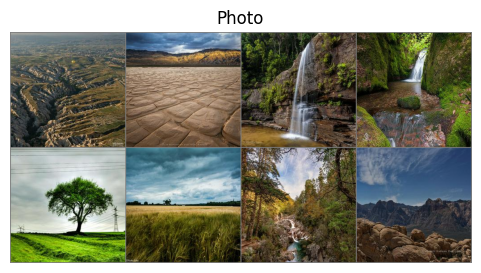

In [9]:
temp = make_grid(base, nrow=4, padding=2).permute(1, 2, 0).detach().numpy()
temp = temp * 0.5 + 0.5
temp = temp * 255.0
temp = temp.astype(int)

fig = plt.figure(figsize=(18, 3), facecolor='w')
plt.imshow(temp)
plt.axis('off')
plt.title('Photo')
plt.show()

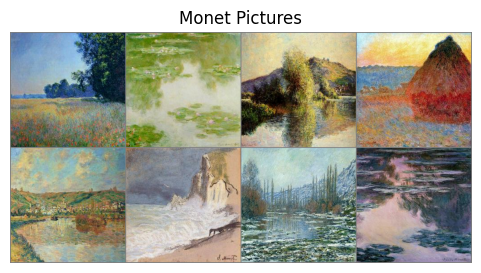

In [10]:
temp = make_grid(style, nrow=4, padding=2).permute(1, 2, 0).detach().numpy()
temp = temp * 0.5 + 0.5
temp = temp * 255.0
temp = temp.astype(int)

fig = plt.figure(figsize=(18, 3), facecolor='w')
plt.imshow(temp)
plt.axis('off')
plt.title('Monet Pictures')
plt.show()

Build CycleGAN network

In [18]:
class Upsample(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1, dropout=True):
        super(Upsample, self).__init__()
        self.dropout = dropout
        self.block = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=nn.InstanceNorm2d),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        self.dropout_layer = nn.Dropout2d(0.5)

    def forward(self, x, shortcut=None):
        x = self.block(x)
        if self.dropout:
            x = self.dropout_layer(x)

        if shortcut is not None:
            x = torch.cat([x, shortcut], dim=1)

        return x

class Downsample(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1, apply_instancenorm=True):
        super(Downsample, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=nn.InstanceNorm2d)
        self.norm = nn.InstanceNorm2d(out_channels)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        self.apply_norm = apply_instancenorm

    def forward(self, x):
        x = self.conv(x)
        if self.apply_norm:
            x = self.norm(x)
        x = self.relu(x)

        return x

class CycleGAN_Unet_Generator(nn.Module):
    def __init__(self, filter=64):
        super(CycleGAN_Unet_Generator, self).__init__()
        self.downsamples = nn.ModuleList([
            Downsample(3, filter, kernel_size=4, apply_instancenorm=False),  # (b, filter, 128, 128)
            Downsample(filter, filter * 2),  # (b, filter * 2, 64, 64)
            Downsample(filter * 2, filter * 4),  # (b, filter * 4, 32, 32)
            Downsample(filter * 4, filter * 8),  # (b, filter * 8, 16, 16)
            Downsample(filter * 8, filter * 8), # (b, filter * 8, 8, 8)
            Downsample(filter * 8, filter * 8), # (b, filter * 8, 4, 4)
            Downsample(filter * 8, filter * 8), # (b, filter * 8, 2, 2)
        ])

        self.upsamples = nn.ModuleList([
            Upsample(filter * 8, filter * 8),
            Upsample(filter * 16, filter * 8),
            Upsample(filter * 16, filter * 8),
            Upsample(filter * 16, filter * 4, dropout=False),
            Upsample(filter * 8, filter * 2, dropout=False),
            Upsample(filter * 4, filter, dropout=False)
        ])

        self.last = nn.Sequential(
            nn.ConvTranspose2d(filter * 2, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
        
    def forward(self, x):
        skips = []
        for l in self.downsamples:
            x = l(x)
            skips.append(x)

        skips = reversed(skips[:-1])
        for l, s in zip(self.upsamples, skips):
            x = l(x, s)

        out = self.last(x)

        return out

class CycleGAN_Discriminator(nn.Module):
    def __init__(self, filter=64):
        super(CycleGAN_Discriminator, self).__init__()

        self.block = nn.Sequential(
            Downsample(3, filter, kernel_size=4, stride=2, apply_instancenorm=False),
            Downsample(filter, filter * 2, kernel_size=4, stride=2),
            Downsample(filter * 2, filter * 4, kernel_size=4, stride=2),
            Downsample(filter * 4, filter * 8, kernel_size=4, stride=1),
        )

        self.last = nn.Conv2d(filter * 8, 1, kernel_size=4, stride=1, padding=1)

    def forward(self, x):
        x = self.block(x)
        x = self.last(x)

        return x

Check the output network

In [19]:
# Sanity Check
net = CycleGAN_Unet_Generator()

out = net(base)
print(out.size())

torch.Size([8, 3, 256, 256])


In [20]:
# Sanity Check
net = CycleGAN_Discriminator()

out = net(base)
print(out.size())

torch.Size([8, 1, 30, 30])


Training the CycleGAN model

In [27]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import make_grid
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


class CycleGAN_LightningSystem(pl.LightningModule):
    def __init__(self, G_basestyle, G_stylebase, D_base, D_style, lr, transform,
                 reconstr_w=10, id_w=2):
        super(CycleGAN_LightningSystem, self).__init__()

        # networks
        self.G_basestyle = G_basestyle
        self.G_stylebase = G_stylebase
        self.D_base = D_base
        self.D_style = D_style

        # hyperparams
        self.lr = lr
        self.transform = transform
        self.reconstr_w = reconstr_w
        self.id_w = id_w

        # losses
        self.mae = nn.L1Loss()
        self.generator_loss = nn.MSELoss()
        self.discriminator_loss = nn.MSELoss()

        # bookkeeping
        self.cnt_train_step = 0
        self.step = 0
        self.losses = []
        self.G_mean_losses = []
        self.D_mean_losses = []
        self.validity = []
        self.reconstr = []
        self.identity = []

        # multiple optimizers → manual optimization in Lightning 2.x
        self.automatic_optimization = False

        # store per-batch outputs for epoch-level stats
        self._train_epoch_outputs = []

    # ------------------------------------------------------------------
    # Optimizers
    # ------------------------------------------------------------------
    def configure_optimizers(self):
        self.g_basestyle_optimizer = optim.Adam(
            self.G_basestyle.parameters(), lr=self.lr['G'], betas=(0.5, 0.999)
        )
        self.g_stylebase_optimizer = optim.Adam(
            self.G_stylebase.parameters(), lr=self.lr['G'], betas=(0.5, 0.999)
        )
        self.d_base_optimizer = optim.Adam(
            self.D_base.parameters(), lr=self.lr['D'], betas=(0.5, 0.999)
        )
        self.d_style_optimizer = optim.Adam(
            self.D_style.parameters(), lr=self.lr['D'], betas=(0.5, 0.999)
        )

        # Lightning will return 4 optimizers; we’ll drive them manually
        return [
            self.g_basestyle_optimizer,
            self.g_stylebase_optimizer,
            self.d_base_optimizer,
            self.d_style_optimizer,
        ]

    # ------------------------------------------------------------------
    # Training step (manual optimization, no optimizer_idx)
    # ------------------------------------------------------------------
    def training_step(self, batch, batch_idx):
        base_img, style_img = batch
        b = base_img.size(0)
        device = base_img.device

        # real / fake targets on correct device
        valid = torch.ones(b, 1, 30, 30, device=device)
        fake = torch.zeros(b, 1, 30, 30, device=device)

        # get optimizers
        opt_g_base, opt_g_style, opt_d_base, opt_d_style = self.optimizers()

        # --------------------------------------------------------------
        # 1) GENERATOR UPDATE (G_basestyle, G_stylebase)
        # --------------------------------------------------------------
        # GAN (validity) loss
        val_base = self.generator_loss(self.D_base(self.G_stylebase(style_img)), valid)
        val_style = self.generator_loss(self.D_style(self.G_basestyle(base_img)), valid)
        val_loss = (val_base + val_style) / 2

        # reconstruction loss
        reconstr_base = self.mae(self.G_stylebase(self.G_basestyle(base_img)), base_img)
        reconstr_style = self.mae(self.G_basestyle(self.G_stylebase(style_img)), style_img)
        reconstr_loss = (reconstr_base + reconstr_style) / 2

        # identity loss
        id_base = self.mae(self.G_stylebase(base_img), base_img)
        id_style = self.mae(self.G_basestyle(style_img), style_img)
        id_loss = (id_base + id_style) / 2

        # total generator loss
        G_loss = val_loss + self.reconstr_w * reconstr_loss + self.id_w * id_loss

        # manual optimization for generators
        opt_g_base.zero_grad()
        opt_g_style.zero_grad()
        self.manual_backward(G_loss)
        opt_g_base.step()
        opt_g_style.step()

        # --------------------------------------------------------------
        # 2) DISCRIMINATOR UPDATE (D_base, D_style)
        # --------------------------------------------------------------
        # use .detach() so D doesn't backprop through G again
        fake_base = self.G_stylebase(style_img).detach()
        fake_style = self.G_basestyle(base_img).detach()

        D_base_gen_loss = self.discriminator_loss(self.D_base(fake_base), fake)
        D_style_gen_loss = self.discriminator_loss(self.D_style(fake_style), fake)
        D_base_valid_loss = self.discriminator_loss(self.D_base(base_img), valid)
        D_style_valid_loss = self.discriminator_loss(self.D_style(style_img), valid)

        D_gen_loss = (D_base_gen_loss + D_style_gen_loss) / 2
        D_loss = (D_gen_loss + D_base_valid_loss + D_style_valid_loss) / 3

        opt_d_base.zero_grad()
        opt_d_style.zero_grad()
        self.manual_backward(D_loss)
        opt_d_base.step()
        opt_d_style.step()

        # count global training steps
        self.cnt_train_step += 1

        # combine for epoch-level stats
        combined_loss = (G_loss + D_loss) / 2

        self._train_epoch_outputs.append({
            "loss": combined_loss.detach(),
            "G_loss": G_loss.detach(),
            "D_loss": D_loss.detach(),
            "validity": val_loss.detach(),
            "reconstr": reconstr_loss.detach(),
            "identity": id_loss.detach(),
        })

        # optional live logs to progress bar
        self.log("G_loss", G_loss, prog_bar=True, on_step=True, on_epoch=False)
        self.log("D_loss", D_loss, prog_bar=True, on_step=True, on_epoch=False)

        # Lightning expects some loss; return G_loss for monitoring
        return G_loss

    # ------------------------------------------------------------------
    # Epoch end (Lightning 2.x: no outputs arg)
    # ------------------------------------------------------------------
    def on_train_epoch_end(self):
        self.step += 1

        if len(self._train_epoch_outputs) == 0:
            return

        # aggregate stats across epoch
        losses = torch.stack([x["loss"] for x in self._train_epoch_outputs])
        G_losses = torch.stack([x["G_loss"] for x in self._train_epoch_outputs])
        D_losses = torch.stack([x["D_loss"] for x in self._train_epoch_outputs])
        validity_vals = torch.stack([x["validity"] for x in self._train_epoch_outputs])
        reconstr_vals = torch.stack([x["reconstr"] for x in self._train_epoch_outputs])
        identity_vals = torch.stack([x["identity"] for x in self._train_epoch_outputs])

        avg_loss = losses.mean().item()
        G_mean_loss = G_losses.mean().item()
        D_mean_loss = D_losses.mean().item()
        validity = validity_vals.mean().item()
        reconstr = reconstr_vals.mean().item()
        identity = identity_vals.mean().item()

        self.losses.append(avg_loss)
        self.G_mean_losses.append(G_mean_loss)
        self.D_mean_losses.append(D_mean_loss)
        self.validity.append(validity)
        self.reconstr.append(reconstr)
        self.identity.append(identity)

        # clear storage for next epoch
        self._train_epoch_outputs = []



Initialize the weights

In [28]:
def init_weights(net, init_type='normal', gain=0.02):
    """
    Initialize network weights like common GAN tutorials.
    init_type: 'normal', 'xavier', 'kaiming', 'orthogonal'
    """
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (
            isinstance(m, nn.Conv2d)
            or isinstance(m, nn.ConvTranspose2d)
            or isinstance(m, nn.Linear)
        ):
            if init_type == 'normal':
                nn.init.normal_(m.weight.data, 0.0, gain)
            elif init_type == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init_type == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                nn.init.orthogonal_(m.weight.data, gain=gain)
            else:
                raise NotImplementedError(f'init method {init_type} is not implemented')

            if m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)

        elif isinstance(m, (nn.BatchNorm2d, nn.InstanceNorm2d)):
            if hasattr(m, 'weight') and m.weight is not None:
                nn.init.normal_(m.weight.data, 1.0, gain)
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)

    net.apply(init_func)


In [29]:
data_dir = '/kaggle/input/gan-getting-started'
transform = ImageTransform(img_size=256)
batch_size = 1

lr = {
    'G': 0.0002,
    'D': 0.0002,
}

epoch = 3   # maybe start smaller like 5–10 while debugging
seed = 42
reconstr_w = 10
id_w = 2

seed_everything(seed)

# DataModule  -----------------------------------------------------------------
dm = MonetDataModule(data_dir, transform, batch_size, seed=seed)

# Models ----------------------------------------------------------------------
G_basestyle = CycleGAN_Unet_Generator()
G_stylebase = CycleGAN_Unet_Generator()
D_base = CycleGAN_Discriminator()
D_style = CycleGAN_Discriminator()

# Init weights ---------------------------------------------------------------
for net in [G_basestyle, G_stylebase, D_base, D_style]:
    init_weights(net, init_type='normal')

# LightningModule ------------------------------------------------------------
model = CycleGAN_LightningSystem(
    G_basestyle,
    G_stylebase,
    D_base,
    D_style,
    lr,
    transform,
    reconstr_w,
    id_w,
)

# Trainer (CPU) --------------------------------------------------------------
trainer = Trainer(
    max_epochs=epoch,
    accelerator="cpu",
    devices=1,
    logger=False,               # ✨ turn off TensorBoard logger
    enable_checkpointing=False, # optional: no checkpoints
)

trainer.fit(model, datamodule=dm)

Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name               | Type                    | Params | Mode 
-----------------------------------------------------------------------
0 | G_basestyle        | CycleGAN_Unet_Generator | 41.8 M | train
1 | G_stylebase        | CycleGAN_Unet_Generator | 41.8 M | train
2 | D_base             | CycleGAN_Discriminator  | 2.8 M  | train
3 | D_style            | CycleGAN_Discriminator  | 2.8 M  | train
4 | mae                | L1Loss                  | 0      | train
5 | generator_loss     | MSELoss                 | 0      | train
6 | discriminator_loss | MSELoss                 | 0      | train
-----------------------------------------------------------------------
89.2 M    Trainable params
0         Non-trainable params
89.2 M    Total params
356.723   Total estimated model params size (MB)
181       Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


The result tells me that - loss decreased

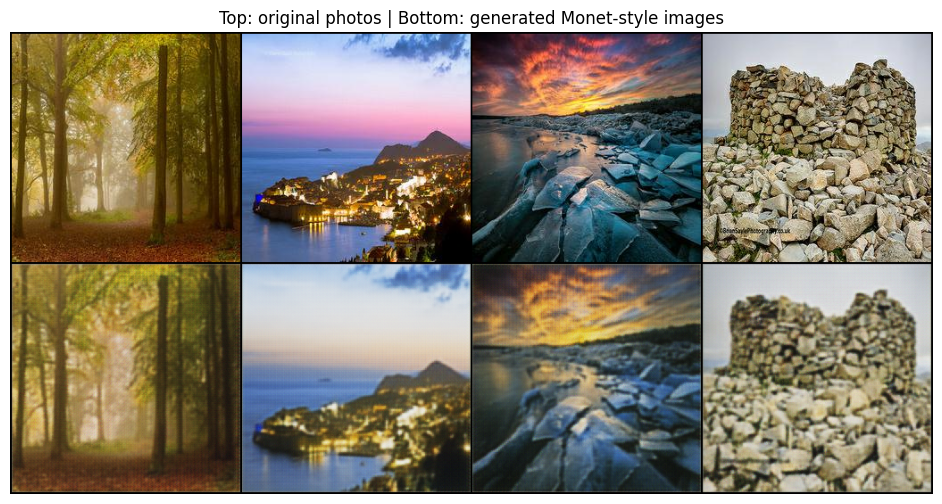

In [31]:
# put model in eval mode
model.eval()
device = next(model.parameters()).device  # should be cpu

# pick a few sample photos from the dataset
photo_paths = glob.glob(data_dir + "/photo_jpg/*.jpg")[:4]

# load and transform
imgs = [transform(Image.open(p), phase='test') for p in photo_paths]
imgs = torch.stack(imgs, dim=0).to(device)  # shape: (4, 3, 256, 256)

with torch.no_grad():
    gen = model.G_basestyle(imgs)           # generated Monet-style images

# de-normalize from [-1, 1] back to [0, 1]
orig = (imgs * 0.5 + 0.5).clamp(0, 1)
gen  = (gen  * 0.5 + 0.5).clamp(0, 1)

# stack originals on top of generated
both = torch.cat([orig, gen], dim=0)       # (8, 3, 256, 256)

grid = make_grid(both, nrow=4, padding=2)
npimg = grid.cpu().numpy().transpose(1, 2, 0)

plt.figure(figsize=(12, 6))
plt.imshow(npimg.astype(np.float32))
plt.axis("off")
plt.title("Top: original photos | Bottom: generated Monet-style images")
plt.show()

Conclustion: The original photoes are successfully converted to Monet Style. Please see the images above.